#### Challenge
The participants are asked to forecast bike rental demand of Bike sharing program in Washington, D.C based on historical usage patterns in relation with weather, time and other data.

Using these Bike Sharing systems, people rent a bike from one location and return it to a different or same place on need basis. People can rent a bike through membership (mostly regular users) or on demand basis (mostly casual users). This process is controlled by a network of automated kiosk across the city.

#### Step 1. Hypothesis Generation

Before exploring the data to understand the relationship between variables, I’d recommend you to focus on hypothesis generation first. Now, this might sound counter-intuitive for solving a data science problem, but if there is one thing I have learnt over years, it is this. Before exploring data, you should spend some time thinking about the business problem, gaining the domain knowledge and may be gaining first hand experience of the problem.

###### Here are some of the hypothesis which I thought could influence the demand of bikes:

* Hourly trend: There must be high demand during office timings. Early morning and late evening can have different trend (cyclist) and low demand during 10:00 pm to 4:00 am.
* Daily Trend: Registered users demand more bike on weekdays as compared to weekend or holiday.
* Rain: The demand of bikes will be lower on a rainy day as compared to a sunny day. Similarly, higher humidity will cause to lower the demand and vice versa.
* Temperature: In India, temperature has negative correlation with bike demand. But, after looking at Washington’s temperature graph, I presume it may have positive correlation.
* Pollution: If the pollution level in a city starts soaring, people may start using Bike (it may be influenced by government / company policies or increased awareness).
* Time: Total demand should have higher contribution of registered user as compared to casual because registered user base would increase over time.
* Traffic: It can be positively correlated with Bike demand. Higher traffic may force people to use bike as compared to other road transport medium like car, taxi etc

In [1]:
import sys
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Supress unnecessary warnings so that presentation looks clean
import warnings
warnings.filterwarnings('ignore')


In [2]:
#read in training and test data
train = pd.read_csv(r'C:\Users\piush\Desktop\Dataset\BikeSharing/train.csv', parse_dates=["datetime"])
test = pd.read_csv(r'C:\Users\piush\Desktop\Dataset\BikeSharing/test.csv', parse_dates=["datetime"])

print ('data loaded')
print (str(len(train))+" rows for training set")
print (str(len(test))+" rows for test set")
print(train.columns)
print(test.columns)


data loaded
10886 rows for training set
6493 rows for test set
Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')
Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')


##### Understanding the Data Set

The dataset shows hourly rental data for two years (2011 and 2012). The training data set is for the first 19 days of each month. The test dataset is from 20th day to month’s end. We are required to predict the total count of bikes rented during each hour covered by the test set.

In the training data set, they have separately given bike demand by registered, casual users and sum of both is given as count.

Training data set has 12 variables (see below) and Test has 9 (excluding registered, casual and count).

###### Independent Variables

    * datetime:   date and hour in "mm/dd/yyyy hh:mm" format
    * season:     Four categories-> 1 = spring, 2 = summer, 3 = fall, 4 = winter
    * holiday:    whether the day is a holiday or not (1/0)
    * workingday: whether the day is neither a weekend nor holiday (1/0)
    * weather:    Four Categories of weather
            1-> Clear, Few clouds, Partly cloudy, Partly cloudy
            2-> Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
            3-> Light Snow and Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
            4-> Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
    * temp:       hourly temperature in Celsius
    * atemp:      "feels like" temperature in Celsius
    * humidity:   relative humidity
    * windspeed:  wind speed
###### Dependent Variables

    * registered: number of registered user
    * casual:     number of non-registered user
    * count:      number of total rentals (registered + casual)

###### Combine both Train and Test Data set (to understand the distribution of independent variable together). 

Before combing test and train data set, I have made the structure similar for both.

In [3]:
test['registered'] = 0
test['casual'] = 0
test['count'] = 0
data = train.append(test, ignore_index = True)

#### 1. Variable Type Identification

In [4]:
print ("\n\n---------------------")
print ("DATA SET INFORMATION")
print ("---------------------")
print ("Shape of data set:", data.shape, "\n")
print ("Column Headers:", list(data.columns.values), "\n")
print (data.dtypes)



---------------------
DATA SET INFORMATION
---------------------
Shape of data set: (17379, 12) 

Column Headers: ['atemp', 'casual', 'count', 'datetime', 'holiday', 'humidity', 'registered', 'season', 'temp', 'weather', 'windspeed', 'workingday'] 

atemp                float64
casual                 int64
count                  int64
datetime      datetime64[ns]
holiday                int64
humidity               int64
registered             int64
season                 int64
temp                 float64
weather                int64
windspeed            float64
workingday             int64
dtype: object


In [5]:
import re
missing_values = []
nonumeric_values = []

print ("DATA SET INFORMATION")
print ("========================\n")

for column in data:
    # Find all the unique feature values
    uniq = data[column].unique()
    print ("'{}' has {} unique values" .format(column,uniq.size))
    if (uniq.size > 10):
        print("~~Listing up to 10 unique values~~")
    print (uniq[0:10])
    print ("\n-----------------------------------------------------------------------\n")
    
    # Find features with missing values
    if (True in pd.isnull(uniq)):
        s = "{} has {} missing" .format(column, pd.isnull(data[column]).sum())
        missing_values.append(s)
    
    # Find features with non-numeric values
    for i in range (1, np.prod(uniq.shape)):
        if (re.match('nan', str(uniq[i]))):
            break
        if not (re.search('(^\d+\.?\d*$)|(^\d*\.?\d+$)', str(uniq[i]))):
            nonumeric_values.append(column)
            break
  
print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
print ("Features with missing values:\n{}\n\n" .format(missing_values))
print ("Features with non-numeric values:\n{}" .format(nonumeric_values))
print ("\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

DATA SET INFORMATION

'atemp' has 65 unique values
~~Listing up to 10 unique values~~
[ 14.395  13.635  12.88   17.425  19.695  16.665  21.21   22.725  21.97
  20.455]

-----------------------------------------------------------------------

'casual' has 309 unique values
~~Listing up to 10 unique values~~
[ 3  8  5  0  2  1 12 26 29 47]

-----------------------------------------------------------------------

'count' has 823 unique values
~~Listing up to 10 unique values~~
[16 40 32 13  1  2  3  8 14 36]

-----------------------------------------------------------------------

'datetime' has 17379 unique values
~~Listing up to 10 unique values~~
['2011-01-01T00:00:00.000000000' '2011-01-01T01:00:00.000000000'
 '2011-01-01T02:00:00.000000000' '2011-01-01T03:00:00.000000000'
 '2011-01-01T04:00:00.000000000' '2011-01-01T05:00:00.000000000'
 '2011-01-01T06:00:00.000000000' '2011-01-01T07:00:00.000000000'
 '2011-01-01T08:00:00.000000000' '2011-01-01T09:00:00.000000000']

------------------

###### Above you can see that it has returned no missing values in the data frame.

######  2. Understand the distribution of numerical variables and generate a frequency table for numeric variables.  

Now, I’ll test and plot a histogram for each numerical variables and analyze the distribution.

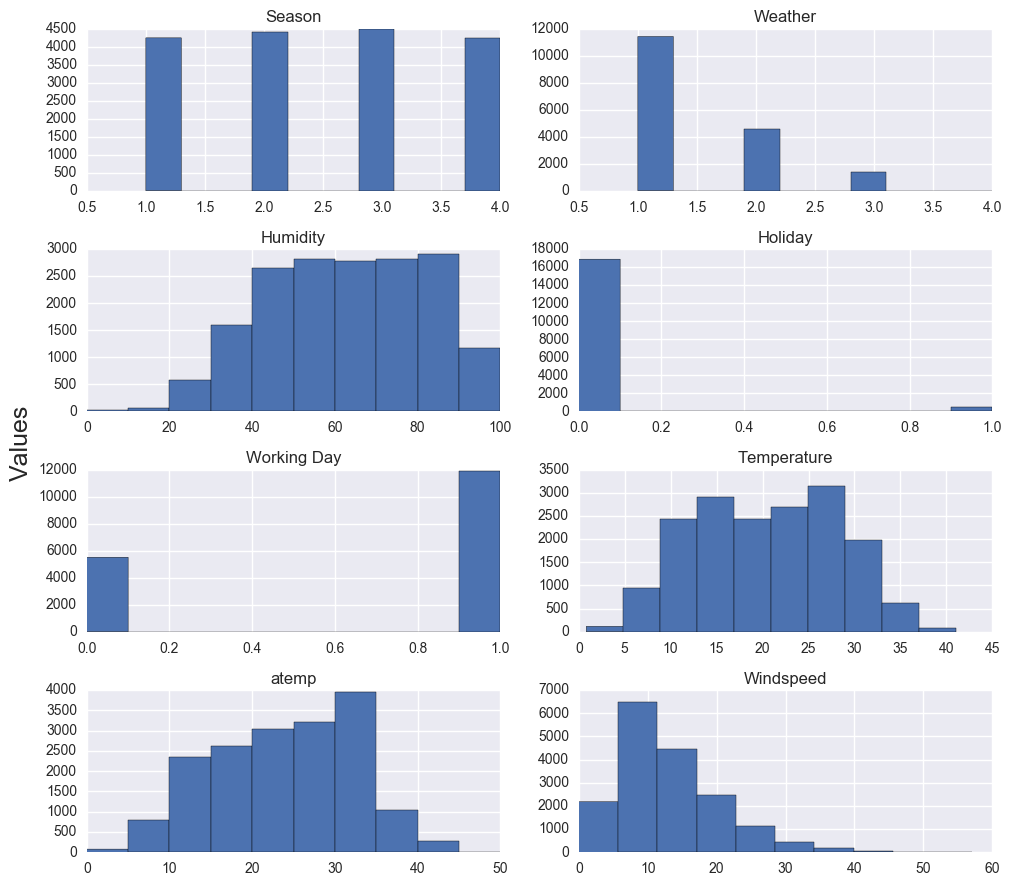

In [6]:
plt.figure(1)
f, axarr = plt.subplots(4, 2, figsize=(10, 9))
axarr[0, 0].hist(data['season'].values)
axarr[0, 0].set_title('Season')
axarr[0, 1].hist(data.weather.values)
axarr[0, 1].set_title('Weather')
axarr[1, 0].hist(data.humidity.values)
axarr[1, 0].set_title('Humidity')
axarr[1, 1].hist(data['holiday'].values)
axarr[1, 1].set_title('Holiday')
axarr[2, 0].hist(data.workingday.values)
axarr[2, 0].set_title('Working Day')
axarr[2, 1].hist(data.temp.values)
axarr[2, 1].set_title('Temperature')
axarr[3, 0].hist(data.atemp.values)
axarr[3, 0].set_title('atemp')
axarr[3, 1].hist(data.windspeed.values)
axarr[3, 1].set_title('Windspeed')
f.text(-0.01, 0.5, 'Values', va='center', rotation='vertical', fontsize = 18)
plt.tight_layout()
plt.show()

###### Few inferences can be drawn by looking at the these histograms:

    * Season has four categories of almost equal distribution
    * Weather 1 has higher contribution i.e. mostly clear weather.

In [7]:
# Frequency Table for weather (Count %)
weatherTable = pd.crosstab(index=data["weather"], columns="count")

weatherTable/weatherTable.sum()

col_0,count
weather,
1,0.656712
2,0.261465
3,0.081650
4,0.000173


    * As expected, mostly working days and variable holiday is also showing a similar inference. You can use the code above to look at the distribution in detail. Here you can generate a variable for weekday using holiday and working day. Incase, if both have zero values, then it must be a working day.
    * Variables temp, atemp, humidity and windspeed  looks naturally distributed.

##### 3. Hypothesis Testing (using multivariate analysis)

Till now, we have got a fair understanding of the data set. Now, let’s test the hypothesis which we had generated earlier.  Here I have added some additional hypothesis from the dataset. Let’s test them one by one:

* Hourly trend: We don’t have the variable ‘hour’ with us right now. But we can extract it using the datetime column.

In [8]:
data["hour"] = pd.DatetimeIndex(data['datetime']).hour


Let’s plot the hourly trend of count over hours and check if our hypothesis is correct or not. We will separate train and test data set from combined one.

In [9]:
train = data[:train.shape[0]]
test = data[train.shape[0]:]

In [10]:
print (str(len(train))+" rows for training set")
print (str(len(test))+" rows for test set")

10886 rows for training set
6493 rows for test set


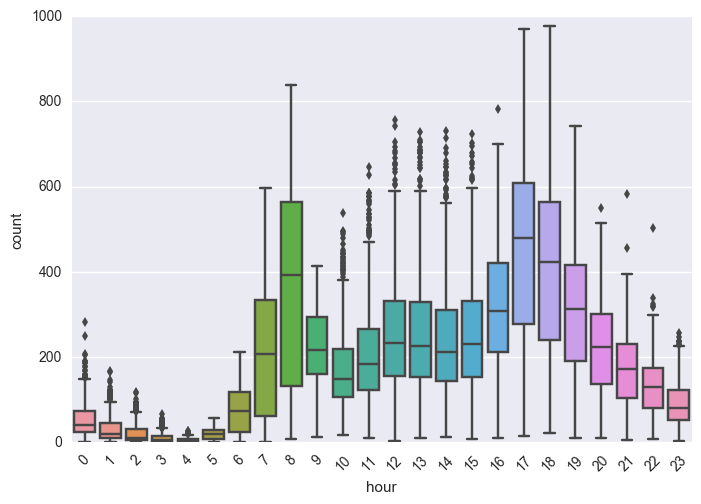

In [11]:
sns.boxplot(x = 'hour', y = 'count',  data = train)
xt = plt.xticks(rotation=45)

Above, you can see the trend of bike demand over hours. Quickly, I’ll segregate the bike demand in three categories:

    * High       : 7-9 and 17-19 hours
    * Average  : 10-16 hours
    * Low         : 0-6 and 20-24 hours

Here I have analyzed the distribution of total bike demand. Let’s look at the distribution of registered and casual users separately.

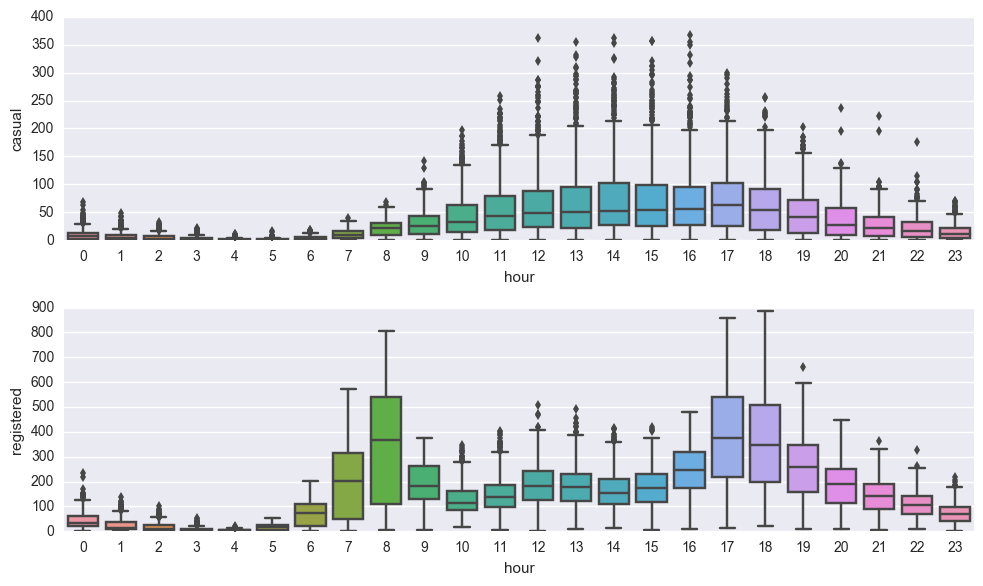

In [12]:
fig, ax = plt.subplots(2, 1, figsize = (10, 6))
sns.boxplot(x = 'hour', y = 'casual', data = train, ax = ax[0])
sns.boxplot(x = 'hour', y = 'registered', data = train, ax = ax[1])
plt.tight_layout()

Above you can see that registered users have similar trend as count. Whereas, casual users have different trend. Thus, we can say that ‘hour’ is significant variable and our hypothesis is ‘true’.

You might have noticed that there are a lot of outliers while plotting the count of registered and casual users. These values are not generated due to error, so we consider them as natural outliers. They might be a result of groups of people taking up cycling (who are not registered). To treat such outliers, we will use logarithm transformation. Let’s look at the similar plot after log transformation.

In [13]:
train['log_count'] = np.log(train['count'])

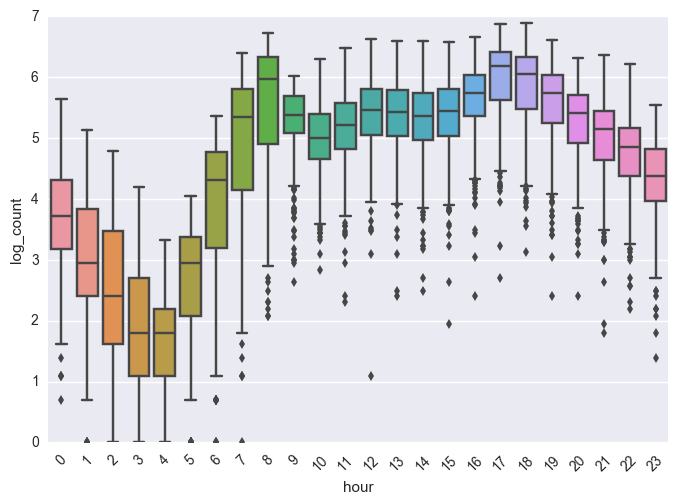

In [15]:
sns.boxplot(x = 'hour', y = 'log_count',  data = train)
xt = plt.xticks(rotation=45)

* Daily Trend: Like Hour, we will generate a variable for day from datetime variable and after that we’ll plot it.

In [21]:
train["day"] = pd.DatetimeIndex(train['datetime']).day

###### Plot shows registered and casual users’ demand over days.

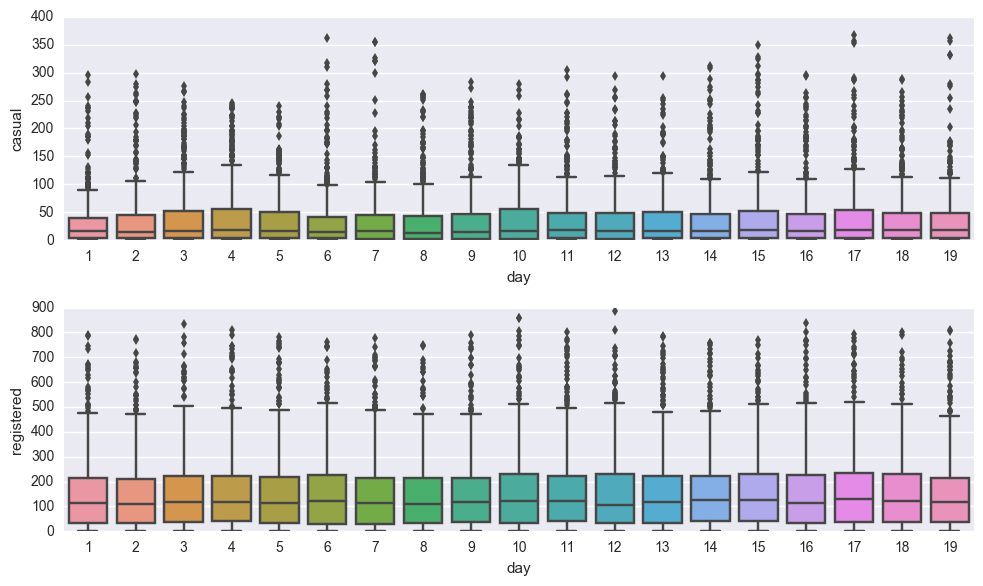

In [22]:
fig, ax = plt.subplots(2, 1, figsize = (10, 6))
sns.boxplot(x = 'day', y = 'casual', data = train, ax = ax[0])
sns.boxplot(x = 'day', y = 'registered', data = train, ax = ax[1])
plt.tight_layout()

While looking at the plot, I can say that the demand of causal users increases over weekend.

* Weather: As per variable description, weather 3 represents light rain and weather 4 represents heavy rain. Take a look at the plot:

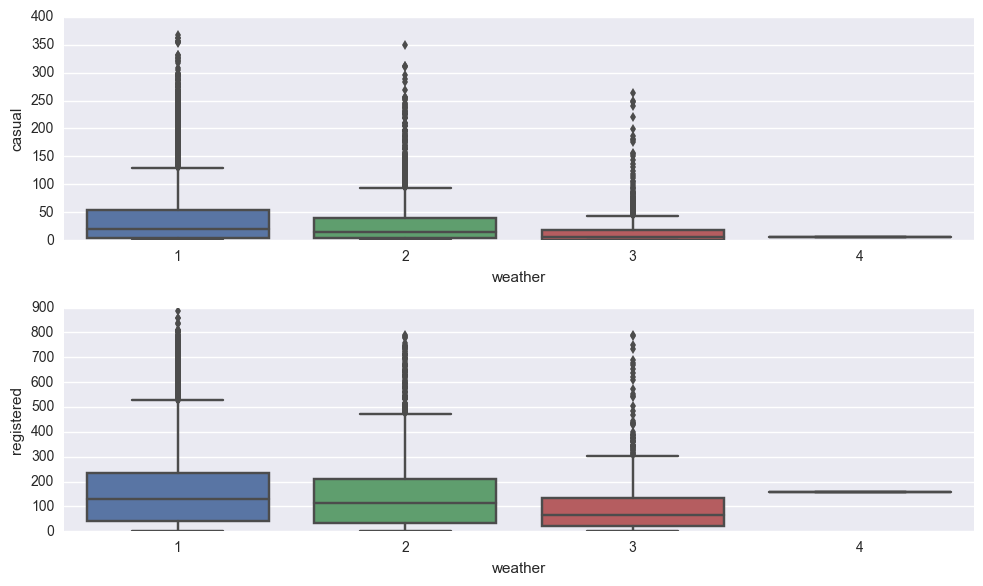

In [23]:
fig, ax = plt.subplots(2, 1, figsize = (10, 6))
sns.boxplot(x = 'weather', y = 'casual', data = train, ax = ax[0])
sns.boxplot(x = 'weather', y = 'registered', data = train, ax = ax[1])
plt.tight_layout()

It is clearly satisfying our hypothesis.
    * Temperature, Windspeed and Humidity: These are continuous variables so we can look at the correlation factor to validate hypothesis.

In [29]:
# Indexing and Slicing in Python
#http://chris.friedline.net/2015-12-15-rutgers/lessons/python2/02-index-slice-subset.html
#http://stackoverflow.com/questions/19237878/subsetting-a-python-dataframe
sub = train[['registered','casual','count','temp','humidity','atemp','windspeed']]
corr = sub.corr()

In [30]:
corr

,registered,casual,count,temp,humidity,atemp,windspeed
registered,1.000000,0.497250,0.970948,0.318571,-0.265458,0.314635,0.091052
casual,0.497250,1.000000,0.690414,0.467097,-0.348187,0.462067,0.092276
count,0.970948,0.690414,1.000000,0.394454,-0.317371,0.389784,0.101369
temp,0.318571,0.467097,0.394454,1.000000,-0.064949,0.984948,-0.017852
humidity,-0.265458,-0.348187,-0.317371,-0.064949,1.000000,-0.043536,-0.318607
atemp,0.314635,0.462067,0.389784,0.984948,-0.043536,1.000000,-0.057473
windspeed,0.091052,0.092276,0.101369,-0.017852,-0.318607,-0.057473,1.000000


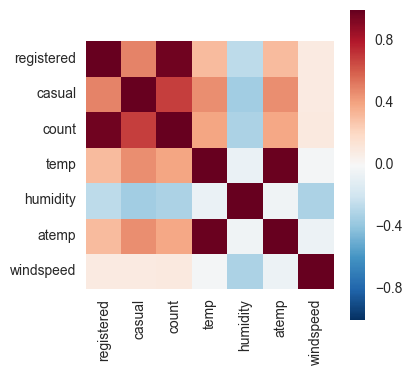

In [34]:
plt.figure(figsize=(4, 4))
sns.heatmap(corr, vmax=1, square=True)

Here are a few inferences you can draw by looking at the above histograms:

        * Variable temp is positively correlated with dependent variables (casual is more compare to registered)
        * Variable atemp is highly correlated with temp.
        * Windspeed has lower correlation as compared to temp and humidity
    * Time: Let’s extract year of each observation from the datetime column and see the trend of bike demand over year.

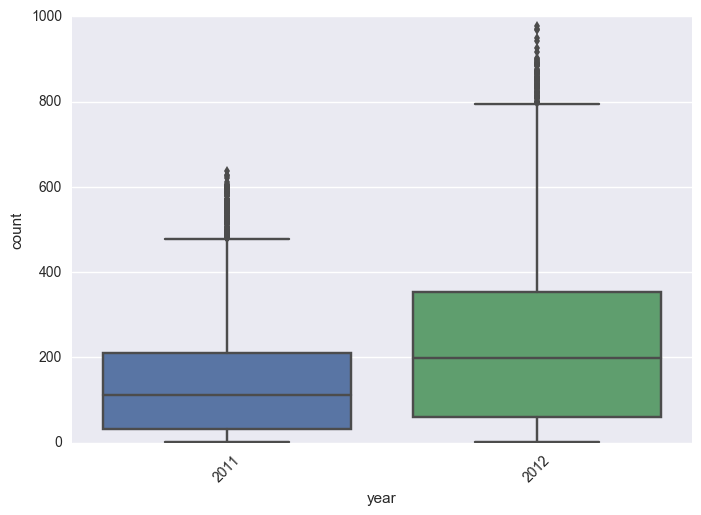

In [35]:
train["year"] = pd.DatetimeIndex(train['datetime']).year
sns.boxplot(x = 'year', y = 'count',  data = train)
xt = plt.xticks(rotation=45)

You can see that 2012 has higher bike demand as compared to 2011.

* Pollution & Traffic: We don’t have the variable related with these metrics in our data set so we cannot test this hypothesis.

##### 4. Feature Engineering

In addition to existing independent variables, we will create new variables to improve the prediction power of model. Initially, you must have noticed that we generated new variables like hour, month, day and year.

Here we will create more variables, let’s look at the some of these:

    * Hour Bins: Initially, we have broadly categorize the hour into three categories. Let’s create bins for the hour variable separately for casual and registered users. Here we will use decision tree to find the accurate bins.

Now, looking at the nodes we can created by decision tree there are  different hour bucket for registered users.

    * data=rbind(train,test)
    * data$dp_reg=0
    * data$dp_reg[data$hour<8]=1
    * data$dp_reg[data$hour>=22]=2
    * data$dp_reg[data$hour>9 & data$hour<18]=3
    * data$dp_reg[data$hour==8]=4
    * data$dp_reg[data$hour==9]=5
    * data$dp_reg[data$hour==20 | data$hour==21]=6
    * data$dp_reg[data$hour==19 | data$hour==18]=7

In [55]:
data= train.append(test, ignore_index = True)


In [62]:
del data['dp_reg']


In [71]:
data['hour < 8'] = data.loc[data.hour < 8] = 1
data['hour >= 22'] = data.loc[data.hour >= 22] = 2
data['hour > 9 & < 18'] = data.loc[(data.hour > 9) & (data.hour < 18) ] = 3
data['hour == 8'] = data.loc[data.hour == 8] = 4
data['hour == 9 '] = data.loc[data.hour == 9] = 5
data['hour ==20 9 & ==21'] = data.loc[(data.hour == 20) & (data.hour == 21) ] = 6
data['hour == 19 & == 18'] = data.loc[(data.hour == 9) & (data.hour == 18) ] = 7





In [70]:
data.head(5)

,atemp,casual,count,datetime,day,holiday,hour,humidity,log_count,registered,season,temp,weather,windspeed,workingday,year,hour < 8,hour >= 22,hour > 9 & < 18,hour == 8
0,1.0,1,1,1970-01-01 00:00:00.000000001,1.0,1,1,1,1.0,1,1,1.0,1,1.0,1,1.0,1,2,3,1
1,1.0,1,1,1970-01-01 00:00:00.000000001,1.0,1,1,1,1.0,1,1,1.0,1,1.0,1,1.0,1,2,3,1
2,1.0,1,1,1970-01-01 00:00:00.000000001,1.0,1,1,1,1.0,1,1,1.0,1,1.0,1,1.0,1,2,3,1
3,1.0,1,1,1970-01-01 00:00:00.000000001,1.0,1,1,1,1.0,1,1,1.0,1,1.0,1,1.0,1,2,3,1
4,1.0,1,1,1970-01-01 00:00:00.000000001,1.0,1,1,1,1.0,1,1,1.0,1,1.0,1,1.0,1,2,3,1


##### Modelling

atemp                 float64
casual                  int64
count                   int64
day                   float64
holiday                 int64
hour                    int32
humidity                int64
log_count             float64
registered              int64
season                  int64
temp                  float64
weather                 int64
windspeed             float64
workingday              int64
year                  float64
hour < 8                int64
hour >= 22              int64
hour > 9 & < 18         int64
hour == 8               int64
hour == 9               int64
hour ==20 9 & ==21      int64
hour == 19 & == 18      int64
dtype: object